# Deep Learning

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from plot_keras_history import show_history, plot_history
import plotly.graph_objects as go
import kaleido

In [126]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.regularizers import L1L2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from scipy.stats import zscore

In [127]:
%store -r final_df
final_df

,Temp,Humidity,Wind,Rain,ISI,Actual Fire
0,8.2,51.0,6.7,0.0,5.1,0.0
1,18.0,33.0,0.9,0.0,6.7,0.0
2,14.6,33.0,1.3,0.0,6.7,0.0
3,8.3,97.0,4.0,0.2,9.0,0.0
4,11.4,99.0,1.8,0.0,9.6,0.0
...,...,...,...,...,...,...
756,30.0,65.0,14.0,0.0,4.5,1.0
757,28.0,87.0,15.0,4.4,0.1,0.0
758,27.0,87.0,29.0,0.5,0.4,0.0
759,24.0,54.0,18.0,0.1,1.7,0.0


In [128]:
# Remove the outliers
final_df_remove_outliers = final_df[(np.abs(zscore(final_df)) < 3).all(axis=1)]

final_df.index.difference(final_df_remove_outliers.index)

Int64Index([ 11,  22, 266, 499, 519, 608, 609, 610, 621, 622, 633, 640, 655,
            656, 657, 676, 735, 736, 757, 758],
           dtype='int64')

In [129]:
# Scale the data
x = final_df_remove_outliers.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final_df_scaled = pd.DataFrame(x_scaled)

## Building The Model

Split the dataframe into seperate parts for training and testing

In [130]:
classification_x = final_df_scaled.iloc[:,: -2].values
classification_y = final_df_scaled.iloc[:,-1 :].values

In [131]:
print(classification_x.shape, classification_y.shape)

(740, 4) (740, 1)


In [132]:
regression_x = final_df_scaled.iloc[:,: -2].values
regression_y = final_df_scaled.iloc[:,-2:-1].values

In [133]:
print(regression_x.shape, regression_y.shape)

(740, 4) (740, 1)


In [134]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(classification_x,classification_y, test_size=0.25, random_state=0)
X_train_rg, X_test_rg, y_train_rg, y_test_rg = train_test_split(regression_x,regression_y, test_size=0.25, random_state=0)

In [135]:
# Build the model with Functional API
# Look at https://keras.io/guides/functional_api/
def build_model():
    inputs = Input(shape=(4,))
    # Classification portion of model
    layer_class = Dense(32,kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer1-cl')(inputs)
    layer_class = Dropout(0.1)(layer_class)
    layer_class = Dense(8, kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer2-cl')(layer_class)
    layer_class = Dense(4, kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer3-cl')(layer_class)
    layer_class = Dropout(0.1)(layer_class)
    output_class = Dense(1, activation='sigmoid',name='classification')(layer_class)
    # Regression portion of model
    layer_reg = Dense(128,activation='relu',name='layer1-reg')(inputs)
    layer_reg = Dense(64,activation='relu',name='layer2-reg')(layer_reg)
    layer_reg = Dense(32,activation='relu',name='layer3-reg')(layer_reg)
    layer_reg = Dense(8,activation='relu',name='layer5-reg')(layer_reg)
    layer_reg = Dense(4,activation='relu',name='layer6-reg')(layer_reg)
    output_reg = Dense(1, activation='linear',name='regression')(layer_reg)
    # Final Model
    model = Model(inputs=inputs, outputs=[output_class,output_reg],name="double_model")
    return model

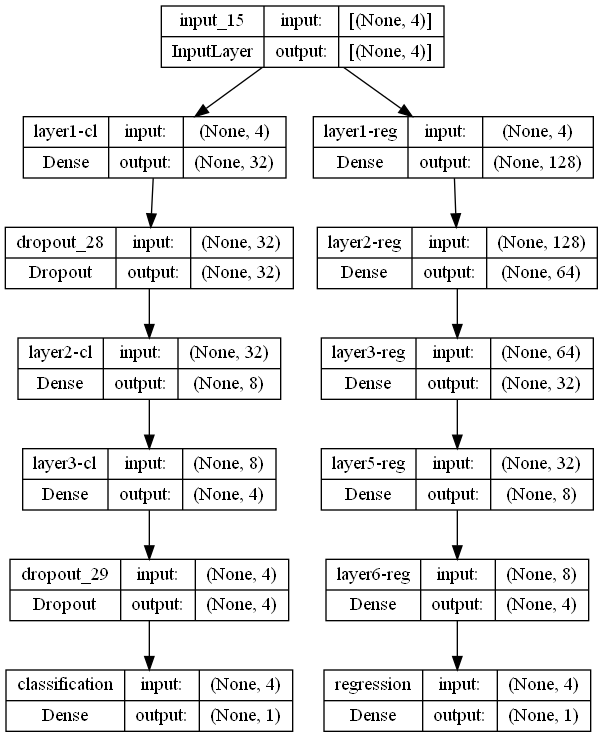

In [136]:
# Verifying outline of model
model = build_model()
keras.utils.plot_model(model, "Images/double_model.png", show_shapes=True)

In [137]:
# Compile the model 
from keras import metrics
model = build_model()
model.compile(
    loss=['binary_crossentropy', 'mse'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["binary_accuracy", 'accuracy']
)

## Run the Model

In [138]:
EPOCHS = 101
num_of_epochs = np.array(range(1,EPOCHS))
n_split=10

loss_cl, acc_cl, loss_rg, y_test_rg_lst, predict_rg_lst, lst_of_epochs  = [], [], [], [], [], []

# Using KFolds to test more on our data since we have a smaller dataset
for train_index,test_index in KFold(n_split).split(classification_x):
    X_train_cl,X_test_cl=classification_x[train_index],classification_x[test_index]
    y_train_cl,y_test_cl=classification_y[train_index],classification_y[test_index]
    X_train_rg,X_test_rg=regression_x[train_index],regression_x[test_index]
    y_train_rg,y_test_rg=regression_y[train_index],regression_y[test_index]
    
    # Fitting the model
    history = model.fit(x=X_train_cl,y=[y_train_cl,y_train_rg],batch_size=16, verbose=0,shuffle=True, epochs = EPOCHS,steps_per_epoch=int(X_train_cl.shape[0]/16))
    
    # Appending values to list for plotting purposes
    class_loss = history.history["classification_loss"]
    loss_cl.append(class_loss)
    
    class_acc = history.history["classification_binary_accuracy"]
    acc_cl.append(class_acc)
    
    reg_loss = history.history['regression_loss']
    loss_rg.append(reg_loss)
    
    y_test_rg = [float(i) for i in y_test_rg]
    y_test_rg_lst.append(y_test_rg)
    
    tmp_test = model.predict(X_test_rg)
    predict_rg = tmp_test[1]
    predict_rg = [float(i) for i in predict_rg]
    predict_rg_lst.append(predict_rg)
    
    lst_of_epochs.append(num_of_epochs)

3/3 [==============================] - 0s 1ms/step


## Plot the Model

In [151]:
def plot_kfold(x,y,xname,yname,type_of_plot,title_of_plot):
    
    fig = go.Figure()
    
    mode_type = ''
    if type_of_plot == 'loss' or type_of_plot == 'acc':
        mode_type = 'lines'
    else:
        mode_type = 'markers'
    
    for i in range(len(x)):
        fig.add_trace(go.Scatter(x=x[i], y=y[i],
                        mode=mode_type,
                        name=f'Fold Number {i+1}'))
        
    # If the plot if for a regression line
    if mode_type == 'markers':
        flatten_x = [i for lst in x for i in lst]
        flatten_y = [i for lst in y for i in lst]
        ary_x = np.array(flatten_x)
        ary_y = np.array(flatten_y)            
        model_lin = LinearRegression().fit(np.vstack(ary_x), ary_y)
        temp_reg_x = ary_x.reshape(-1, 1)
        temp_reg_y = ary_y.reshape(-1, 1)
        r_squared = model_lin.score(temp_reg_y, temp_reg_x)
        bestfit = model_lin.predict(temp_reg_x)
        # Run model on x data
        fig.add_trace(
            go.Scatter(
                x=flatten_x,
                y=bestfit,
                mode="lines",
                opacity=0.8,
                marker=dict(color="Blue"),
                name=f'Trendline Over All Folds: {str(round(float(model_lin.coef_[0]), 2)) + "x " + str(round(model_lin.intercept_, 2))}',
            )
        )
        fig.add_trace(
            go.Scatter(
                x=flatten_x,
                y=[bestfit[0]],
                name="R-squared Over All Fold: " + str(round(r_squared, 2)),
                showlegend=True,
                mode="markers",
                marker=dict(color="rgba(0,0,0,0)"),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=[0.8],
                y=[0.25],
                mode="text",
                text=f"R-squared: {str(round(r_squared, 2))}",
                showlegend=False,
            )
        )

        
        
        
    fig.update_layout(title=title_of_plot, xaxis_title=xname,yaxis_title=yname,
                      font=dict(
                          family="Courier New, monospace",
                          size=14))
    fig.write_image(f"Images/{title_of_plot}.png",engine="kaleido")
    fig.show()

In [152]:
plot_kfold(lst_of_epochs,loss_cl,'Num of Epochs','Loss', 'loss', 'Classification Loss For Each Fold')
plot_kfold(lst_of_epochs,acc_cl,'Num of Epochs','Accuracy', 'acc', 'Classification Acc For Each Fold')
plot_kfold(lst_of_epochs,loss_rg,'Num of Epochs','Loss', 'loss', 'Regression Loss For Each Fold')
plot_kfold(y_test_rg_lst,predict_rg_lst,'Actual','Predicted', 'predict', 'Actual and Predicted Regression Values For Each Fold')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## Results/Conclusions

From the final plots we can see that out classification model is performing about the same as the machine learning approach or sometimes worse. This shows that there may be room for imporvement or that there isnt enough data in general - even with the kfold - to increase accuracy. As for the regression we see that we get much better R2 values compared to the machine learning approach. Using just a single deep learning model we can see that we can save time and achieve equal or greater results than using a machine learning approach when it comes to classifying and predicting a fire and its initial spread.